In [1]:
import tensorflow as tf
import boto3, os
from tensorflow import keras
from tensorflow.keras.layers import Input, Embedding, Concatenate, Dense
import pandas as pd
from io import StringIO
import numpy as np
import matplotlib.pyplot as plt

2025-11-30 02:48:10.851461: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-11-30 02:48:10.851841: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-11-30 02:48:10.947659: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-11-30 02:48:13.310147: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To tur

## Training Parameters:

In [2]:
EPOCHS = 15
BATCHSIZE = 32

TRAIN_PERCENTAGE = 0.8

**Idea:**

inputs:


_ list np.array of index for the weather

        0 = snow or rain
        1 = heavy cloudy/ Windy
        2= cloudy
        3 = blue sky

_ list np.array of temperature in °C

_ Traffic time in minutes

In [11]:
# Architecture:
def DNN():
    input_id_skatepark = Input(shape = (15,), name= 'id_skateparks')
    input_weather  = Input(shape=(15,), name='weather_input')
    input_temp     = Input(shape=(15,), name='weather_temp')
    intput_traffic = Input(shape=(15,), name='weather_traffic')

    # Embedding to create vectors for index:
    emb_skatepark = Embedding(input_dim=15 + 1, output_dim=5)(input_id_skatepark)
    emb_skatepark = tf.keras.layers.Flatten()(emb_skatepark)
    
    emb_weather = Embedding(input_dim=4 + 1, output_dim=2)(input_weather)
    emb_weather = tf.keras.layers.Flatten()(emb_weather)

    concat_features = Concatenate()([
        emb_skatepark,
        emb_weather,
        input_temp,
        intput_traffic
    ])


    x = Dense(64, activation='relu')(concat_features)
    x = Dense(32, activation='relu')(x)

    output = Dense(15, activation='sigmoid', name='preference_score')(x)

    model = keras.Model(
        inputs = [input_id_skatepark, input_weather, input_temp, intput_traffic ],
        outputs = output
    )
    optimizer_adam = tf.keras.optimizers.Adam(learning_rate=5e-4) 
    model.compile(
        optimizer=optimizer_adam,
        loss='binary_crossentropy',
        metrics=['mae']
    )
    model.summary()    
    return model

model = DNN()


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ id_skateparks       │ (None, 15)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ weather_input       │ (None, 15)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_4         │ (None, 15, 5)     │         80 │ id_skateparks[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_5         │ (None, 15, 2)     │         10 │ weather_input[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_4 (Flatten) │ (None, 75)        │          0 │ embedding_4[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_5 (Flatten) │ (None, 30)        │          0 │ embedding_5[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ weather_temp        │ (None, 15)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ weather_traffic     │ (None, 15)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_2       │ (None, 135)       │          0 │ flatten_4[0][0],  │
│ (Concatenate)       │                   │            │ flatten_5[0][0],  │
│                     │                   │            │ weather_temp[0][… │
│                     │                   │            │ weather_traffic[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 64)        │      8,704 │ concatenate_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 32)        │      2,080 │ dense_4[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ preference_score    │ (None, 15)        │        495 │ dense_5[0][0]     │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 11,369 (44.41 KB)

 Trainable params: 11,369 (44.41 KB)

 Non-trainable params: 0 (0.00 B)

## Generator:

Get access to the S3 bucket:

In [4]:
s3 = boto3.client(
    "s3",
    endpoint_url=os.getenv("S3_ENDPOINT"),
    aws_access_key_id=os.getenv("AWS_ACCESS_KEY_ID"),
    aws_secret_access_key=os.getenv("AWS_SECRET_ACCESS_KEY"),
    region_name="us-east-1"
)

In [5]:
BUCKET_NAME = "skatedata"   
FILE_KEY = "clean_skatepark_dataset.csv"  

obj = s3.get_object(Bucket=BUCKET_NAME, Key=FILE_KEY)
df = pd.read_csv(StringIO(obj['Body'].read().decode('utf-8')))

print(df.head())

     spot_name  index spot  weather  temperature  traffic_time  satisfaction
0     Ahuntsic           0        0         30.5          31.4             0
1     VanHorne           1        0         30.5          31.4             0
2       Verdun           2        0         30.5          31.4             0
3      Lasalle           3        0         30.5          31.4             0
4  Préfontaine           4        0         30.5          31.4             0


In [6]:
from tensorflow.keras.utils import Sequence


class SkateSpotGenerator(Sequence):
    def __init__(self, df, batchsize = 32):
        self.df = df
        self.batchsize = batchsize

        # Group the data by weather:
        self.group_weather = {
            w: df[df["weather"] == w] for w in df["weather"].unique()
        }
        self.n_skateparks = df["index spot"].nunique()
        self.index = 0
        
    def __len__(self):
        return self.df.shape[0] // self.batchsize


    def __getitem__(self, idx):
        id_batch           = []
        weather_batch      = []
        temp_batch         = []
        traffic_batch      = []
        satisfaction_batch = []

        for _ in range(self.batchsize):
            id_spot       = []
            weather       = []
            temp          = []
            traffic       = []
            satisfaction  = []
            row = self.df.iloc[self.index]
            current_weather = row["weather"]

            spot_same_weather = self.group_weather[current_weather]

            for spot_id in spot_same_weather["index spot"].unique():
                candidates = spot_same_weather[spot_same_weather["index spot"] == spot_id]
                random_row = candidates.sample(n=1).iloc[0]
                id_spot.append(random_row["index spot"])
                weather.append(random_row["weather"])
                temp.append(random_row["temperature"])
                traffic.append(random_row["traffic_time"])
                satisfaction.append(random_row["satisfaction"])
            self.index = (self.index + 1) % len(self.df)


            id_batch.append(id_spot)
            weather_batch.append(weather)
            temp_batch.append(temp)
            traffic_batch.append(traffic)
            satisfaction_batch.append(satisfaction)
        
        
        
        return (
                (
                    np.array(id_batch),
                    np.array(weather_batch),
                    np.array(temp_batch),
                    np.array(traffic_batch)
                ), 
                np.array(satisfaction_batch)
                )



In [7]:
df_train = df.sample(frac=TRAIN_PERCENTAGE, random_state=42)  # 80% pour l'entraînement
df_val   = df.drop(df_train.index)               # le reste pour validation

train_generator = SkateSpotGenerator(df = df_train, batchsize = BATCHSIZE)
val_generator   = SkateSpotGenerator(df = df_val, batchsize = BATCHSIZE)

In [12]:
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=EPOCHS,
    verbose=1
)

Epoch 1/15
183/183 ━━━━━━━━━━━━━━━━━━━━ 30s 160ms/step - loss: 0.6620 - mae: 0.2869 - val_loss: 1.1193 - val_mae: 0.4156
Epoch 2/15
183/183 ━━━━━━━━━━━━━━━━━━━━ 30s 163ms/step - loss: 0.1892 - mae: 0.1241 - val_loss: 2.0366 - val_mae: 0.4181
Epoch 3/15
183/183 ━━━━━━━━━━━━━━━━━━━━ 30s 161ms/step - loss: 0.0757 - mae: 0.0497 - val_loss: 2.6639 - val_mae: 0.4176
Epoch 4/15
183/183 ━━━━━━━━━━━━━━━━━━━━ 29s 158ms/step - loss: 0.0563 - mae: 0.0358 - val_loss: 2.9626 - val_mae: 0.4208
Epoch 5/15
183/183 ━━━━━━━━━━━━━━━━━━━━ 29s 156ms/step - loss: 0.0484 - mae: 0.0310 - val_loss: 3.1161 - val_mae: 0.4167
Epoch 6/15
183/183 ━━━━━━━━━━━━━━━━━━━━ 29s 158ms/step - loss: 0.0439 - mae: 0.0280 - val_loss: 3.2235 - val_mae: 0.4105
Epoch 7/15
183/183 ━━━━━━━━━━━━━━━━━━━━ 29s 158ms/step - loss: 0.0423 - mae: 0.0269 - val_loss: 3.3446 - val_mae: 0.4058
Epoch 8/15
183/183 ━━━━━━━━━━━━━━━━━━━━ 29s 160ms/step - loss: 0.0412 - mae: 0.0259 - val_loss: 3.4863 - val_mae: 0.4170
Epoch 9/15
183/183 ━━━━━━━━━━━━━

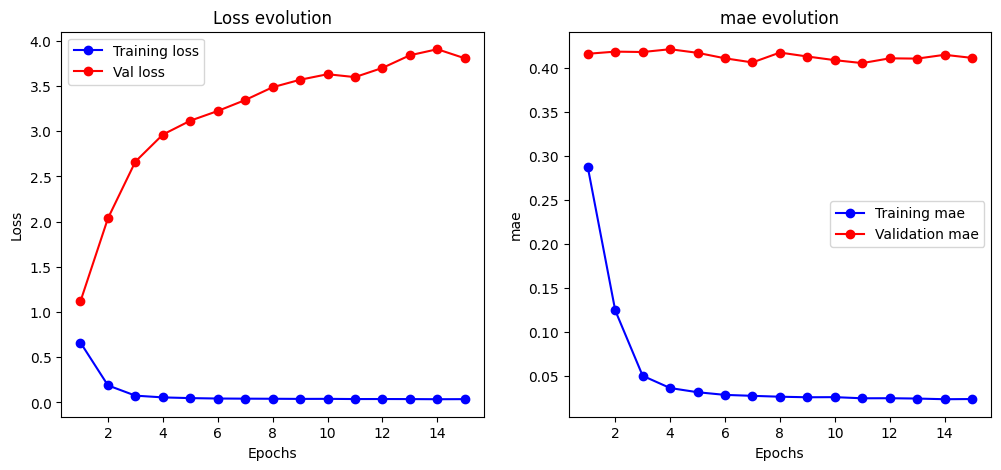

In [13]:
loss = history.history['loss']
val_loss = history.history['val_loss']

mae = history.history.get('mae')
val_mae = history.history.get('val_mae')

epochs = range(1, EPOCHS + 1)

plt.figure(figsize = (12,5))
plt.subplot(1,2,1)
plt.plot(epochs, loss, 'bo-', label = "Training loss")
plt.plot(epochs, val_loss, 'ro-', label = "Val loss")

plt.title("Loss evolution")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1,2,2)
plt.plot(epochs, mae, 'bo-', label='Training mae')
plt.plot(epochs, val_mae, 'ro-', label="Validation mae")
plt.title( "mae evolution")
plt.xlabel('Epochs')
plt.ylabel("mae")
plt.legend()
plt.show()